In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df_final  = pd.read_csv(r"C:\Users\franc\Desktop\ML_IoT\df_final.csv", sep=',' )

In [3]:
df_final.shape

(1460, 79)

### separamos  las variables  predictoras de variable objetivo

In [5]:
## separamos  las variables  predictoras de variable objetivo

X_original  = df_final.drop(columns=["SalePrice"])
y = df_final["SalePrice"]

#### Identificar columnas categóricas y codificación

In [7]:
categorical_cols = X_original.select_dtypes(include=["object"]).columns

# Aplicar Label Encoding a las variables categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_original[col] = le.fit_transform(X_original[col])
    label_encoders[col] = le

### Dividimos conjunto de entrenamiento y prueba

In [9]:
random_seed = 99

X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size=0.2, random_state=42)

### Entrenamiento del modelo para determinar la importancia de las variables

In [11]:
rf_original = RandomForestRegressor(n_estimators=100, random_state=random_seed)

rf_original.fit(X_train, y_train)

RandomForestRegressor(random_state=99)

### Medición de la importancia de las variables originales

In [13]:
# Obtener la importancia de las variables originales
feature_importances_original = pd.DataFrame({
    "Variable": X_original.columns, 
    "Importancia": rf_original.feature_importances_
})

feature_importances_original = feature_importances_original.sort_values(by="Importancia", ascending=False)
feature_importances_original.to_excel(r"C:\Users\franc\Desktop\ML_IoT\importancia_variables.xlsx", index=False)




**Análisis de la importancia de variables con Random Forest**

Muchos autores y profesionales del sector recomiendan establecer un criterio de  Importancia < 0.0005 % para eliminar variables y redicir dimensionalidad.

No obstante podemos desarrollar algún punto del siguiente estudio para aproximar el impacto real de las variables:


+ 1. Visualización de la importancia acumulada

     - Ordenamos las variables de mayor a menor importancia y calculamos la suma acumulada de la importancia.
     - Elegimos un umbral cuando alcanzamos 95%-99% de la importancia total, descartando las de menor contribución.
<br>

+ 2. Prueba iterativa eliminando variables poco importantes

     - Entrenamos el modelo con todas las variables y luego vamos eliminando las de baja importancia hasta que el rendimiento empiece a empeorar.
<br>

+ 3. Método basado en la media de importancia

     - Calculamos la media de la importancia de todas las variables.
     - Eliminamos aquellas por debajo de la media si no afectan significativamente el rendimiento del modelo.
    

### 1.  Visualización de la importancia acumulada

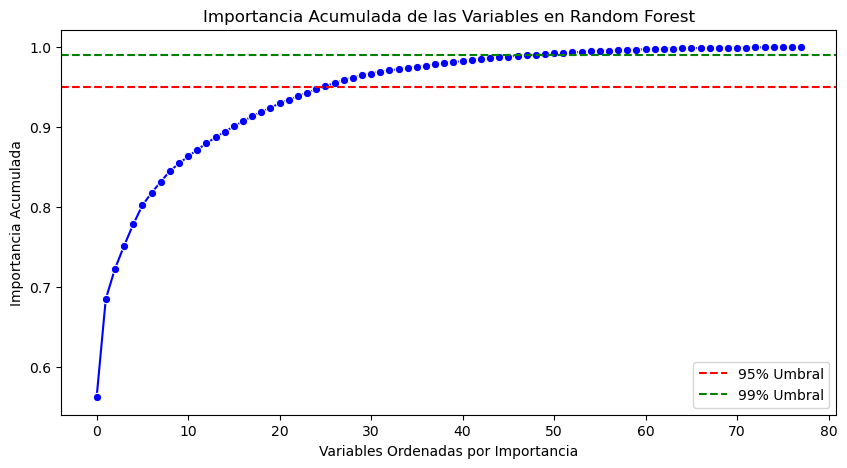

In [16]:
# Calcular la importancia acumulada de las variables
feature_importances_original["Importancia Acumulada"] = feature_importances_original["Importancia"].cumsum()

# Visualizar la importancia acumulada
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(feature_importances_original)), y=feature_importances_original["Importancia Acumulada"], marker="o", color="b")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Umbral")
plt.axhline(y=0.99, color="g", linestyle="--", label="99% Umbral")
plt.xlabel("Variables Ordenadas por Importancia")
plt.ylabel("Importancia Acumulada")
plt.title("Importancia Acumulada de las Variables en Random Forest")
plt.legend()
plt.show()

Resultado para determinar el umbral de importancia basado en la acumulación de impacto en SalePrice.

Teniendo en cuenta que despues de la codificación de las variables categóricas tenemos 305 filas.

+ Resultados obtenidos:

    - Para alcanzar el 95% de la importancia total, necesitamos 26 variables.
    - Para alcanzar el 99% de la importancia total, necesitamos 48 variables.
<br>

+ Conclusión:

    - Para un modelo más compacto y eficiente, podemos quedarnos solo con las 28 variables más importantes.
    - Si queremos retener casi toda la información, podemos quedarnos con las 92 más relevantes y eliminar las menos importantes.

#### 2. Prueba iterativa eliminando variables poco importantes

In [19]:
mean_importance_original = feature_importances_original["Importancia"].mean()

selected_features_original = feature_importances_original[
    feature_importances_original["Importancia"] > mean_importance_original
]

selected_vars = selected_features_original["Variable"].tolist()

df_final_selected = df_final[selected_vars + ["SalePrice"]]


C:\Users\franc\AppData\Local\Temp\ipykernel_19772\2024392135.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_features_original["Variable"], y=selected_features_original["Importancia"], palette="coolwarm")


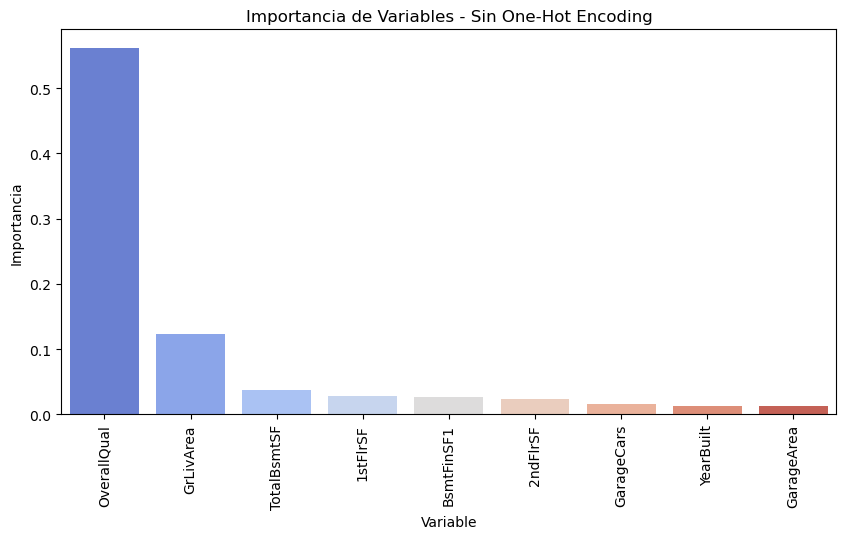

In [20]:
# Visualizar la importancia de las variables seleccionadas
plt.figure(figsize=(10, 5))
sns.barplot(x=selected_features_original["Variable"], y=selected_features_original["Importancia"], palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Importancia de Variables - Sin One-Hot Encoding")
plt.ylabel("Importancia")
plt.xlabel("Variable")
plt.show()

- Tras la prueba iterativa para eliminar variables poco importantes, nos quedamos con las siguientes 9 variables:

    - OverallQual
    - GrLivArea
    - TotalBsmtSF
    - 1stFlrSF
    - BsmtFinSF1
    - 2ndFlrSF
    - GarageCars
    - YearBuilt
    - GarageArea


### Aplicamos One-Hot Encoding solo a las variables categóricas dentro de esta selección y preparar el dataset final.

In [61]:
df_final_selected = df_final[['SalePrice'] + selected_features_original["Variable"].tolist()]

categorical_selected = df_final_selected.select_dtypes(include=["object"]).columns

df_final_encoded = pd.get_dummies(df_final_selected, columns=categorical_selected, drop_first=True)

df_final_encoded 

,SalePrice,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,BsmtFinSF1,2ndFlrSF,GarageCars,YearBuilt,GarageArea
0,208500,7,1710,856,856,706,854,2,2003,548
1,181500,6,1262,1262,1262,978,0,2,1976,460
2,223500,7,1786,920,920,486,866,2,2001,608
3,140000,7,1717,756,961,216,756,3,1915,642
4,250000,8,2198,1145,1145,655,1053,3,2000,836
...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,953,953,0,694,2,1999,460
1456,210000,6,2073,1542,2073,790,0,2,1978,500
1457,266500,7,2340,1152,1188,275,1152,1,1941,252
1458,142125,5,1078,1078,1078,49,0,1,1950,240


In [63]:
df_final_encoded.to_csv(r"C:\Users\franc\Desktop\ML_IoT\df_final_for_training.csv" ,sep=',', index=False )